In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
# import kerastuner as kt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
# from keras.callbacks import EalrlyStopping
# from keras.models import Mode
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import cv2
import matplotlib.patches as patches
import torch

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


بدون سکته: 4428

ایسکمی (Ischemia): 1131

خونریزی (Bleeding): 1094
منبع: سیستم‌های e-Pulse و تله‌رادیولوژی وزارت بهداشت ترکیه

زمانی که ما می خوایم یه شیکه غصبی رو بسازیم گردایان  ها نسبت به لابه ها  مختلف محاسبه می شه 

In [2]:
path = "/kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset" 

In [3]:

detection = [class_name for class_name in os.listdir(path)if class_name != "External_Test"]
detection

['Ischemia', 'Bleeding', 'Normal']

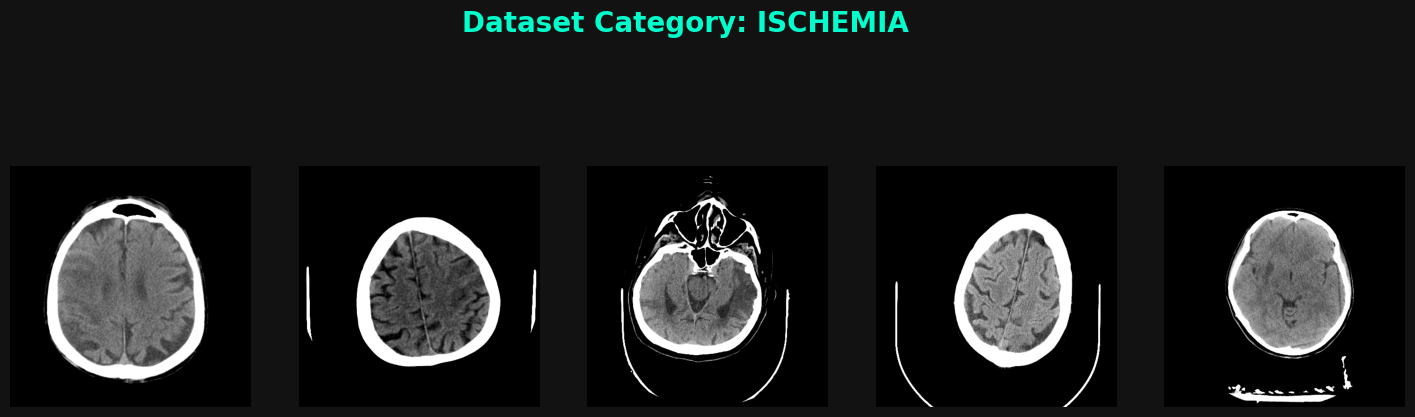

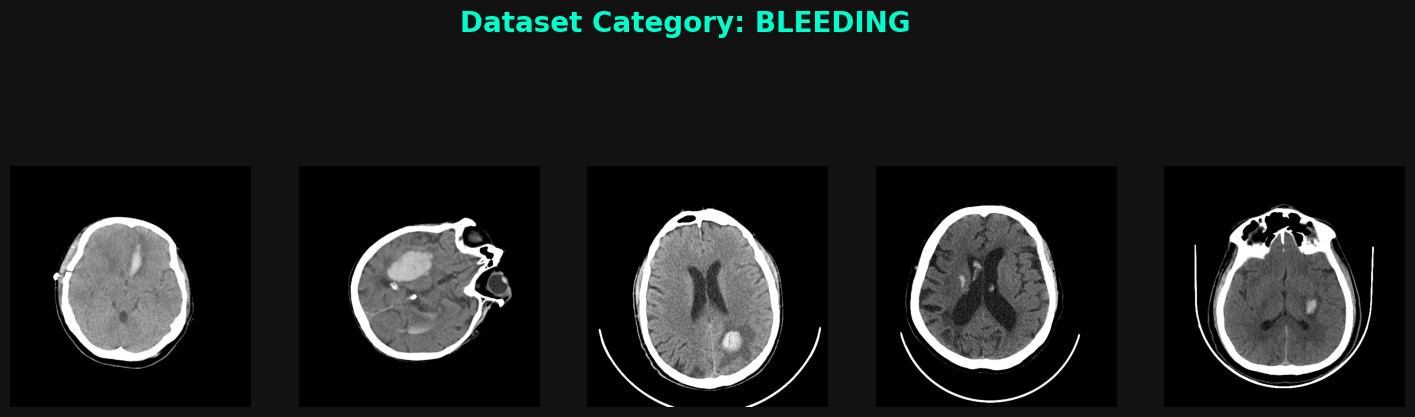

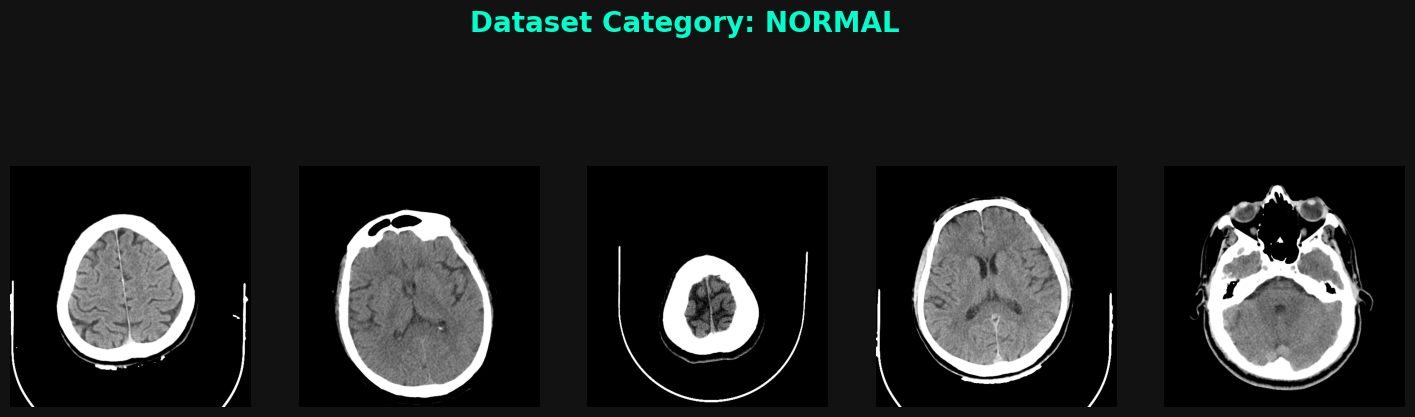

In [4]:
for cls in detection:
    if cls == "External_Test":  
        continue
    folder = os.path.join(path, cls,"PNG")
    images = sorted(os.listdir(folder))

    fig, axes = plt.subplots(1, 5, figsize=(18, 5), facecolor='#121212')
    fig.suptitle(f"Dataset Category: {cls.upper()}",
                 fontsize=20, weight="black", color='#00FFCC', y=1.05)

    for ax, img_name in zip(axes, images[0:0 + 5]):
        img_path = os.path.join(folder, img_name)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  
        ax.imshow(img)
        ax.axis('off')  \

    plt.show()


In [ ]:

classes = [cls for cls in detection if cls != "External_Test"]
image_counts = [len(os.listdir(os.path.join(path, cls, "PNG"))) for cls in classes]
# Radar
angles = np.linspace(0, 2*np.pi, len(classes), endpoint=False).tolist()
plot_counts = image_counts + [image_counts[0]]
plot_angles = angles + [angles[0]]

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw=dict(polar=False))

ax_r = fig.add_subplot(121, polar=True)
ax_r.set_theta_offset(np.pi/2); ax_r.set_theta_direction(-1)
ax_r.plot(plot_angles, plot_counts, color='#E63946', lw=2)
ax_r.fill(plot_angles, plot_counts, color='#E63946', alpha=0.25)
for i, c in enumerate(image_counts):
    ax_r.text(angles[i], c+max(image_counts)*0.02, str(c), ha='center', va='center', weight='bold', size=11)
ax_r.set_xticks(angles); ax_r.set_xticklabels(classes, fontsize=12, fontweight='bold', color='#457B9D')
plt.yticks(color='grey', size=9); ax_r.set_title("Radar Distribution", size=16, weight='bold')

# Pie 
ax2 = fig.add_subplot(122)
ax2.pie(image_counts, labels=classes, autopct='%1.1f%%', colors=sns.color_palette("pastel"), textprops={'weight':'bold'})
ax2.set_title("Percentage Distribution", size=16, weight='bold')

plt.tight_layout()
plt.show()


دیتاست به شدن نامتوازن است    

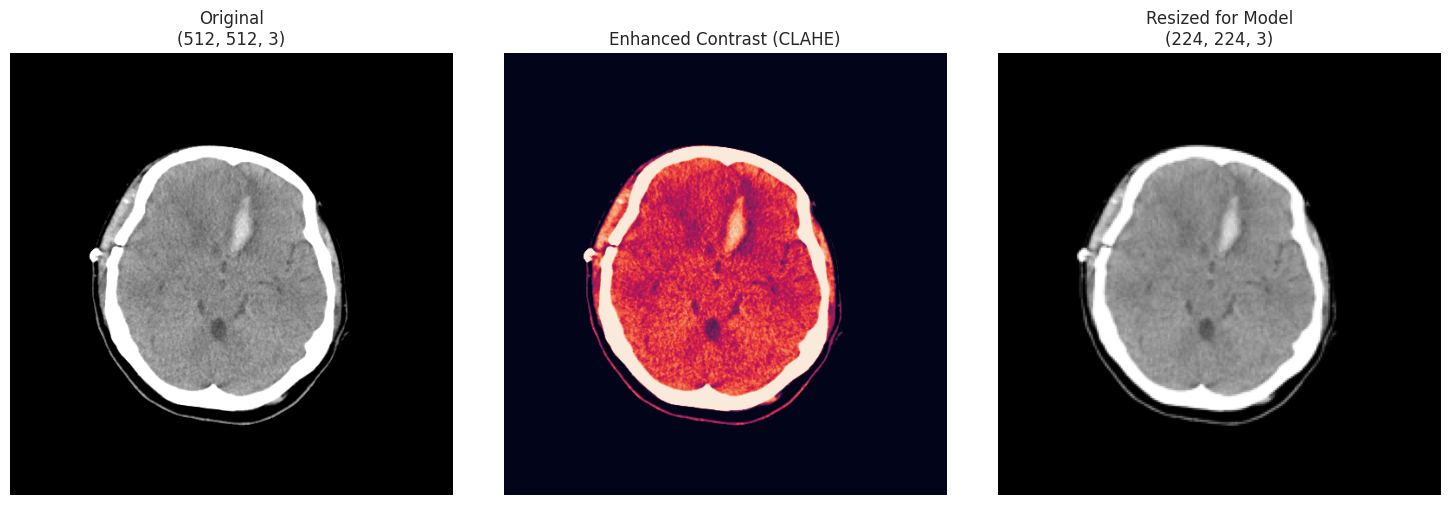

In [36]:
# -------------------------- بارگذاری تصویر --------------------------
img = "/kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Bleeding/PNG/10002.png"
img = cv2.imread(img)
# -------------------------- افزایش کنتراست --------------------------
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced_img = clahe.apply(img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

# -------------------------- تغییر اندازه --------------------------
resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

# -------------------------- نمایش تصاویر --------------------------
images = [img, enhanced_img, resized] # ارایه برای هز 3 بخش 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = [f"Original\n{img.shape[:]}",
          "Enhanced Contrast (CLAHE)",
          f"Resized for Model\n{resized.shape[:]}"]
for ax, im, title in zip(axes, images, titles):
    ax.imshow(im)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

# tensor (MLP)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
my_list = []
for class_name in detection :
    class_path = os.path.join(path, class_name,"PNG")
    files = os.listdir(class_path)
    for file in files :
        file_path = os.path.join(class_path, file)
        my_list.append((file_path, class_name))

# Convert the list to a pandas DataFrame
df = pd.DataFrame(my_list, columns=['file_path', 'label'])

# Shuffle the dataframe rows
df = df.sample(frac=1).reset_index(drop=True)
display(df["label"].value_counts())
df.head()

label
Normal      4427
Ischemia    1130
Bleeding    1093
Name: count, dtype: int64

,file_path,label
0,/kaggle/input/brain-stroke-ct-dataset/Brain_St...,Normal
1,/kaggle/input/brain-stroke-ct-dataset/Brain_St...,Ischemia
2,/kaggle/input/brain-stroke-ct-dataset/Brain_St...,Normal
3,/kaggle/input/brain-stroke-ct-dataset/Brain_St...,Normal
4,/kaggle/input/brain-stroke-ct-dataset/Brain_St...,Ischemia


In [6]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["label"]
)

valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["label"]
)

In [7]:
dataset_size = len(df)  
batch_size = max(16, min(128, dataset_size // 100))
print(batch_size)


66


افزایش کنراست 

In [38]:
def apply_clahe(img):
    img = img.astype("uint8")
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    # برگردوندن به 3 کانال تا با مدل هماهنگ باشه
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    return enhanced / 255.0

In [39]:
# Set the image size and batch size
image_size = (224, 224)
batch_size = 64
datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe
)
# Create a generator for the training data
Train = datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the validation data
Validation = datagen.flow_from_dataframe(
    valid_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create a generator for the test data
Test = datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4655 validated image filenames belonging to 3 classes.
Found 997 validated image filenames belonging to 3 classes.
Found 998 validated image filenames belonging to 3 classes.


In [57]:
print(Train.class_indices)


{'Bleeding': 0, 'Ischemia': 1, 'Normal': 2}


<div style="direction: rtl; font-family: 'Tahoma', 'Arial', sans-serif; line-height: 1.8; border: 2px solid #4A90E2; border-radius: 12px; padding: 25px; background-color: #f9fbfd; color: #333; max-width: 800px; margin: 20px auto; shadow: 0 4px 8px rgba(0,0,0,0.1);">
        <h3 style="color: #27ae60;">2. تابع Cross-Entropy (هزینه)</h3>
        <p>
            این تابع به عنوان <strong>تابع هزینه (Loss Function)</strong> عمل می‌کند. وظیفه آن اندازه‌گیری تفاوت بین پیش‌بینی مدل (که توسط Softmax ساخته شده) و مقادیر واقعی (Label) است.
        </p>
        <p>
            هرچه پیش‌بینی مدل به واقعیت نزدیک‌تر باشد، مقدار این تابع کمتر خواهد بود.
        </p>
        <div style="direction: ltr; background: #eee; padding: 10px; border-radius: 5px; text-align: center; font-weight: bold; font-family: serif;">
            Cross-Entropy: L = -Σ yᵢ log(ŷᵢ)
        </div>
    </div>

</div>
<div style="direction: rtl; font-family: 'Tahoma', 'Arial', sans-serif; line-height: 1.8; border: 2px solid #4A90E2; border-radius: 12px; padding: 25px; background-color: #f9fbfd; color: #333; max-width: 800px; margin: 20px auto; shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <h2 style="color: #2c3e50; border-bottom: 2px solid #4A90E2; padding-bottom: 10px;">بررسی تابع Softmax</h2>
    <div style="padding: 15px; background: #fff; border-right: 5px solid #4A90E2; border-radius: 4px; margin-bottom: 20px;">
        <h3 style="color: #e67e22;">1. کاربرد</h3>
        <p>
            Softmax معمولاً در <strong>لایه خروجی</strong> شبکه عصبی قرار می‌گیرد و اعداد خام (Logits) را به <strong>احتمال هر کلاس</strong> تبدیل می‌کند.
        </p>
        <ul>
            <li>خروجی هر کلاس بین <strong>0 و 1</strong> است.</li>
            <li>مجموع تمام خروجی‌ها دقیقاً برابر با <strong>1</strong> می‌شود.</li>
        </ul>
    </div>
    <div style="padding: 15px; background: #fff; border-right: 5px solid #8e44ad; border-radius: 4px;">
        <h3 style="color: #8e44ad;">2. فرمول Softmax</h3>
         <img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60d24ae385bcde8513aeb8c4_pasted%20image%200%20%2815%29.jpg">
        <div style="direction: ltr; background: #eee; padding: 10px; border-radius: 5px; text-align: center; font-weight: bold; font-family: serif;">
            σ(z)ᵢ = e^(zᵢ) / Σⱼ e^(zⱼ)
        </div>
        <ul>
            <li><strong>zᵢ</strong> = عدد خام (Logit) برای کلاس i</li>
            <li><strong>Σⱼ e^(zⱼ)</strong> = مجموع نمایی تمام کلاس‌ها (برای نرمال کردن)</li>
            <li>خروجی <strong>σ(z)ᵢ</strong> = احتمال پیش‌بینی مدل برای کلاس i</li>
        </ul>
    </div>
    <div style="padding: 15px; background: #fff; border-right: 5px solid #27ae60; border-radius: 4px; margin-top: 20px;">
        <h3 style="color: #27ae60;">3. توضیح ساده</h3>
        <p>
            - هر عدد خام zᵢ با e^(zᵢ) تبدیل می‌شود تا همه مقادیر مثبت شوند. <br>
            - سپس بر مجموع e^(zⱼ) تقسیم می‌شود تا جمع کل خروجی‌ها = ۱ شود. <br>
            - نتیجه: یک توزیع احتمال که می‌توان به راحتی گفت «احتمال تعلق به هر کلاس چقدر است».
        </p>
        <p>مثال ساده: اگر logits = [1, 2, 3] باشد، خروجی Softmax ≈ [0.09, 0.24, 0.67] و جمعشان = 1.</p>
    </div>
    دلایل استفاده از exp:

احتمال نمی‌تواند منفی باشد.

اختلاف‌ها را تقویت می‌کند.
</div>

In [4]:
# ==========================================================
# Utility Functions - توابع کمکی
# ==========================================================
# def relu_derivative(x):
#     return (x > 0).astype(float)

# تابع Softmax برای خروجی دسته‌بندی
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
print("softmax✅")
# تابع Loss: Cross-Entropy
def cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m
print("cross_entropy✅")

softmax✅
cross_entropy✅


In [ ]:

# ==========================================================
# Layers - تعریف لایه‌ها
# ==========================================================
# Flatten: تبدیل ورودی چندبعدی به 2 بعدی (batch_size, features)
class Flatten:
    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.input_shape)


# Dense: لایه کاملاً متصل + به‌روزرسانی Adam
class Dense:
    def __init__(self, in_features, out_features):
        # He initialization
        self.W = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
        self.b = np.zeros((1, out_features))

        # Adam state (مقادیر اولیه برای Momentum و RMSProp)
        self.mW = np.zeros_like(self.W)
        self.vW = np.zeros_like(self.W)
        self.mb = np.zeros_like(self.b)
        self.vb = np.zeros_like(self.b)

    # Forward Pass
    def forward(self, x):
        self.input = x
        self.z = np.dot(x, self.W) + self.b
        return self.z

    # Backward Pass
    def backward(self, grad_output):
        m = self.input.shape[0]
        self.dW = np.dot(self.input.T, grad_output) / m
        self.db = np.sum(grad_output, axis=0, keepdims=True) / m
        return np.dot(grad_output, self.W.T)

    # Update با Adam
    def update(self, lr, t, beta1=0.9, beta2=0.999, eps=1e-8):
        self.mW = beta1 * self.mW + (1 - beta1) * self.dW
        self.vW = beta2 * self.vW + (1 - beta2) * (self.dW ** 2)
        self.mb = beta1 * self.mb + (1 - beta1) * self.db
        self.vb = beta2 * self.vb + (1 - beta2) * (self.db ** 2)

        # Bias correction
        mW_hat = self.mW / (1 - beta1 ** t)
        vW_hat = self.vW / (1 - beta2 ** t)
        mb_hat = self.mb / (1 - beta1 ** t)
        vb_hat = self.vb / (1 - beta2 ** t)

        # آپدیت پارامترها
        self.W -= lr * mW_hat / (np.sqrt(vW_hat) + eps)
        self.b -= lr * mb_hat / (np.sqrt(vb_hat) + eps)



In [ ]:
# ==========================================================
# MLP Model - تعریف مدل شبکه عصبی چندلایه
# ==========================================================
class MLP:
    def __init__(self, input_shape, num_classes):
        flat_dim = np.prod(input_shape)  # flatten dimension

        # ساختار لایه‌ها
        self.flatten = Flatten()
        self.l1 = Dense(flat_dim, 512)
        self.l2 = Dense(512, 256)
        self.l3 = Dense(256, 128)
        self.l4 = Dense(128, num_classes)

        self.layers = [self.l1, self.l2, self.l3, self.l4]

    # Forward Pass
    def forward(self, x):
        x = self.flatten.forward(x)

        x = self.l1.forward(x)
        x = relu(x)

        x = self.l2.forward(x)
        x = relu(x)

        x = self.l3.forward(x)
        x = relu(x)

        x = self.l4.forward(x)
        x = softmax(x)

        return x

    # Backward Pass
    def backward(self, y_true, y_pred):
        grad = (y_pred - y_true)  # softmax + CE derivative

        grad = self.l4.backward(grad)

        grad = relu_derivative(self.l3.z) * grad
        grad = self.l3.backward(grad)

        grad = relu_derivative(self.l2.z) * grad
        grad = self.l2.backward(grad)

        grad = relu_derivative(self.l1.z) * grad
        grad = self.l1.backward(grad)

        grad = self.flatten.backward(grad)

    # Update همه لایه‌ها
    def update(self, lr, t):
        for layer in self.layers:
            layer.update(lr, t)



In [ ]:

# ==========================================================
# Training Loop - آموزش با Mini-batch + Adam
# ==========================================================
def train(model, X, y, epochs=1, batch_size=32, lr=0.001):
    y = one_hot(y, np.max(y) + 1)
    n = X.shape[0]
    t = 0  # Adam timestep

    for epoch in range(epochs):

        # Shuffle داده‌ها
        indices = np.random.permutation(n)
        X = X[indices]
        y = y[indices]

        # Mini-batch
        for i in range(0, n, batch_size):
            t += 1
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            y_pred = model.forward(X_batch)
            model.backward(y_batch, y_pred)
            model.update(lr, t)

        # Evaluate روی کل داده‌ها
        y_pred_full = model.forward(X)
        loss = cross_entropy(y, y_pred_full)
        acc = np.mean(np.argmax(y_pred_full, axis=1) == np.argmax(y, axis=1))

        print(f"Epoch {epoch+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

In [56]:
# ==========================================================
# Summary Function - نمایش تعداد پارامترها
# ==========================================================
def mlp_summary(model):
    total_params = 0
    for i, layer in enumerate(model.layers, 1):
        if isinstance(layer, Dense):
            params = layer.W.size + layer.b.size
            total_params += params
            print(f"Layer {i}: Dense | input: {layer.W.shape[0]} | output: {layer.W.shape[1]} | params: {params}")
    print(f"Total params: {total_params}")


# ==========================================================
# ایجاد مدل و نمایش Summary
# ==========================================================
input_shape = (224, 224, 3)
num_classes = 3  # تعداد کلاس‌ها
model = MLP(input_shape=input_shape, num_classes=num_classes)

mlp_summary(model)

Layer 1: Dense | input: 150528 | output: 512 | params: 77070848
Layer 2: Dense | input: 512 | output: 256 | params: 131328
Layer 3: Dense | input: 256 | output: 128 | params: 32896
Layer 4: Dense | input: 128 | output: 3 | params: 387
Total params: 77235459


In [12]:
class NumpyGradientLogger:
    def __init__(self):
        self.epoch_gradients = []
        self.stats = []

    def log(self, model, epoch):
        kernel_grads = []
        layer_norms = []

        for layer in model.layers:
            if isinstance(layer, Dense):
                grad = layer.dW
                if grad is not None:
                    norm = np.linalg.norm(grad)
                    layer_norms.append(norm)
                    kernel_grads.append(grad)

        self.epoch_gradients.append(layer_norms)

        if len(kernel_grads) >= 2:
            first = kernel_grads[0]
            last = kernel_grads[-1]

            first_mean = np.mean(np.abs(first))
            last_mean = np.mean(np.abs(last))
            first_l2 = np.linalg.norm(first)
            last_l2 = np.linalg.norm(last)
            last_var = np.var(last)
            last_max = np.max(np.abs(last))
            vanishing_ratio = first_mean / (last_mean + 1e-12)

            self.stats.append({
                "epoch": epoch + 1,
                "first_mean": first_mean,
                "last_mean": last_mean,
                "first_l2": first_l2,
                "last_l2": last_l2,
                "last_variance": last_var,
                "last_max": last_max,
                "vanishing_ratio": vanishing_ratio
            })

In [20]:
import time
# تعداد کلاس‌ها از generator
num_classes = len(Train.class_indices)

input_shape = (224, 224, 3)

# ساخت مدل
model = MLP(input_shape=input_shape, num_classes=num_classes)
# ساخت مدل MLP با ابعاد ورودی و تعداد کلاس‌ها
model = MLP(input_shape=input_shape, num_classes=num_classes)
def train_numpy_mlp(model, generator, val_generator=None, epochs=1, lr=0.001):
    logger = NumpyGradientLogger()
    total_batches = len(generator) * epochs
    batch_counter = 0
    start_time = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        epoch_start = time.time()

        for step in range(len(generator)):
            X_batch, y_batch = generator[step]
            y_batch_onehot = one_hot(np.argmax(y_batch, axis=1), y_batch.shape[1])

            # forward
            y_pred = model.forward(X_batch)
            # backward
            model.backward(y_batch_onehot, y_pred)
            # update
            model.update(lr, t=step+1)

            # بروزرسانی شمارنده batch و نمایش زمان تقریبی
            batch_counter += 1
            elapsed = time.time() - start_time
            batches_left = total_batches - batch_counter
            eta = (elapsed / batch_counter) * batches_left
            print(f"\rBatch {batch_counter}/{total_batches} | Elapsed: {elapsed:.1f}s | ETA: {eta:.1f}s", end='')

        # log gradient stats
        logger.log(model, epoch)

        # evaluate training set (optional)
        total_X = np.concatenate([generator[i][0] for i in range(len(generator))], axis=0)
        total_y = np.concatenate([generator[i][1] for i in range(len(generator))], axis=0)
        total_y_onehot = one_hot(np.argmax(total_y, axis=1), total_y.shape[1])
        y_pred_full = model.forward(total_X)
        loss = cross_entropy(total_y_onehot, y_pred_full)
        acc = np.mean(np.argmax(y_pred_full, axis=1) == np.argmax(total_y_onehot, axis=1))
        epoch_time = time.time() - epoch_start
        print(f"\nEpoch {epoch+1} finished in {epoch_time:.1f}s | Loss: {loss:.4f} | Acc: {acc:.4f}")

    total_time = time.time() - start_time
    print(f"\nTraining finished in {total_time:.1f}s")
    return logger


logger = train_numpy_mlp(
    model=model,
    generator=Train,
    val_generator=Validation,
    epochs=2,
    lr=0.001
)

# مشاهده stats گرادیان‌ها
print("\nGradient stats for each epoch:")
for s in logger.stats:
    print(s)


Epoch 1/2
Batch 73/146 | Elapsed: 124.4s | ETA: 124.4s
Epoch 1 finished in 158.1s | Loss: 0.7983 | Acc: 0.7918

Epoch 2/2
Batch 146/146 | Elapsed: 254.1s | ETA: 0.0ss
Epoch 2 finished in 130.2s | Loss: 0.5274 | Acc: 0.8232

Training finished in 288.4s

Gradient stats for each epoch:
{'epoch': 1, 'first_mean': np.float64(5.486225094457111e-05), 'last_mean': np.float64(0.5954697089235852), 'first_l2': np.float64(1.9378741715549028), 'last_l2': np.float64(28.256949731784818), 'last_variance': np.float64(2.0793104378766), 'last_max': np.float64(6.560682366568128), 'vanishing_ratio': np.float64(9.213273172812101e-05)}
{'epoch': 2, 'first_mean': np.float64(4.0189107425015455e-05), 'last_mean': np.float64(0.6845294710562463), 'first_l2': np.float64(1.432604278159965), 'last_l2': np.float64(30.248426652407787), 'last_variance': np.float64(2.3827273826721194), 'last_max': np.float64(8.081491471672994), 'vanishing_ratio': np.float64(5.871055830940914e-05)}


In [43]:
all_preds = []
all_true = []

for i in range(len(Test)):
    X_batch, y_batch = Test[i]
    
    y_pred = model.forward(X_batch)   # چون NumPy MLP هست
    preds = np.argmax(y_pred, axis=1)
    true = np.argmax(y_batch, axis=1)
    
    all_preds.append(preds)
    all_true.append(true)

y_pred_bool = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

from sklearn.metrics import classification_report

clf_report = classification_report(
    y_true,
    y_pred_bool,
    target_names=list(Train.class_indices.keys())
)

print(clf_report)

              precision    recall  f1-score   support

    Bleeding       0.81      0.63      0.71       164
    Ischemia       0.97      0.16      0.28       170
      Normal       0.78      0.99      0.87       664

    accuracy                           0.79       998
   macro avg       0.85      0.60      0.62       998
weighted avg       0.82      0.79      0.74       998



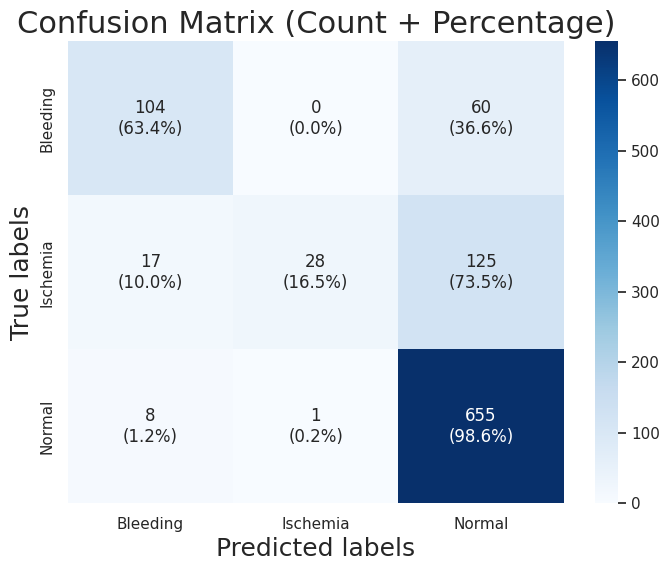

[[104   0  60]
 [ 17  28 125]
 [  8   1 655]]
[164 170 664]


In [41]:
def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)

    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    annot_text = np.empty_like(cm).astype(str)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot_text[i, j] = f"{cm[i, j]}\n({cm_normalized[i, j]*100:.1f}%)"

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm,
                     annot=annot_text,
                     fmt='',
                     cmap="Blues")

    ax.set_xlabel('Predicted labels', fontsize=18)
    ax.set_ylabel('True labels', fontsize=18)
    ax.set_title('Confusion Matrix (Count + Percentage)', fontsize=22)

    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()
    print(cm)
    print(cm.sum(axis=1))
labels = sorted(Test.class_indices, key=Test.class_indices.get)

plot_confusion_matrix(y_true, y_pred_bool, labels)

# بررسی گرادیان هاش 

Index(['epoch', 'first_mean', 'last_mean', 'first_l2', 'last_l2',
       'last_variance', 'last_max', 'vanishing_ratio'],
      dtype='str')


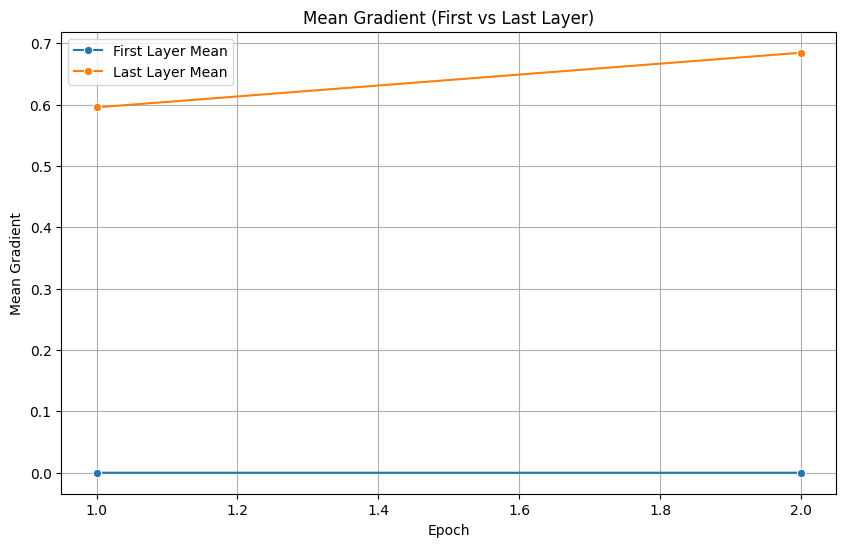

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

grad_df = pd.DataFrame(logger.stats)

# بررسی ستون‌ها
print(grad_df.columns)

# تنظیم اندازه شکل
plt.figure(figsize=(10,6))

# رسم خطوط با seaborn
sns.lineplot(data=grad_df, x="epoch", y="first_mean", label="First Layer Mean", marker="o")
sns.lineplot(data=grad_df, x="epoch", y="last_mean", label="Last Layer Mean", marker="o")

plt.title("Mean Gradient (First vs Last Layer)")
plt.xlabel("Epoch")
plt.ylabel("Mean Gradient")
plt.legend()
plt.grid(True)
plt.show()

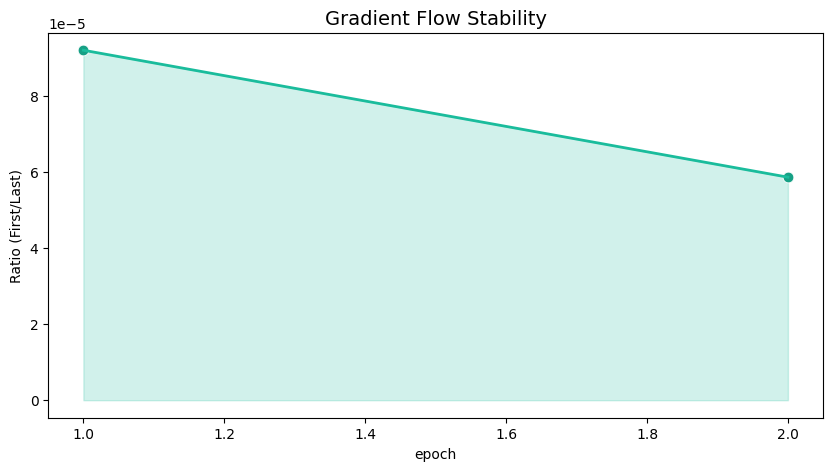

In [25]:
plt.figure(figsize=(10, 5))

# رسم خط
sns.lineplot(data=grad_df, x="epoch", y="vanishing_ratio", color="#1ABC9C", linewidth=2)

# پر کردن زیر نمودار برای جذابیت بصری و درک بهتر حجم
plt.fill_between(grad_df["epoch"], grad_df["vanishing_ratio"], color="#1ABC9C", alpha=0.2)

# اضافه کردن نقاط به صورت جداگانه برای کنترل بیشتر
sns.scatterplot(data=grad_df, x="epoch", y="vanishing_ratio", color="#16A085", s=60)

plt.title("Gradient Flow Stability", fontsize=14)
plt.ylabel("Ratio (First/Last)")
plt.show()

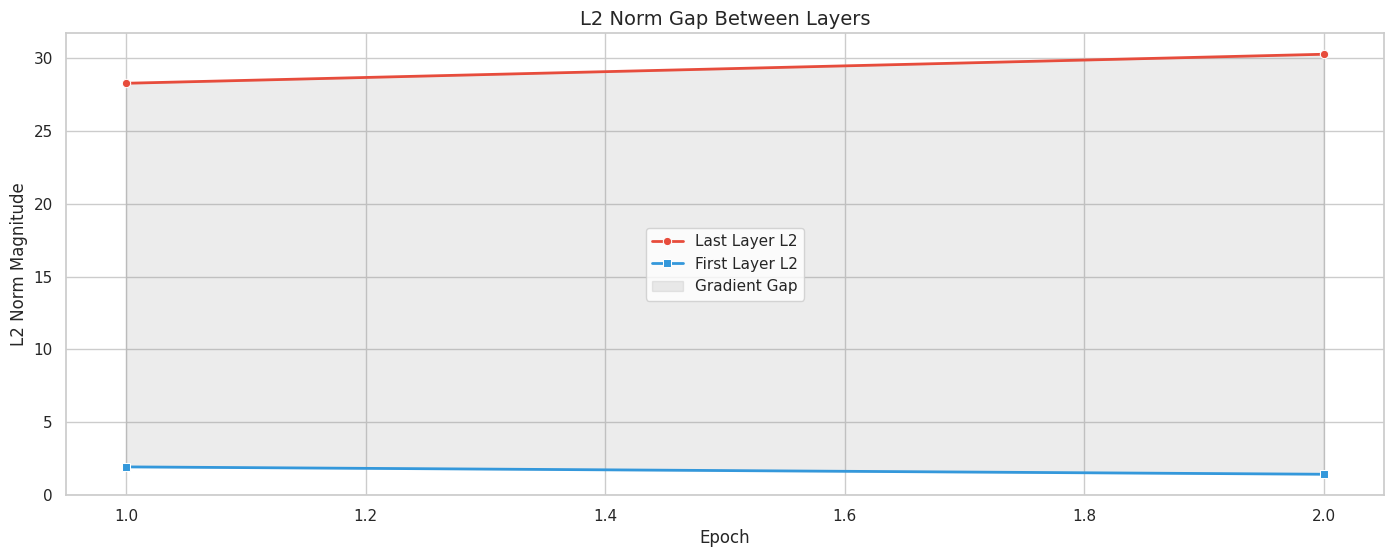

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# تبدیل داده‌ها به فرمت مناسب برای Seaborn
df_melted = grad_df.melt(
    id_vars=['epoch'], 
    value_vars=['first_l2', 'last_l2'], 
    var_name='Layer', 
    value_name='L2_Norm'
)

# تغییر نام‌ها برای نمایش زیباتر در راهنما
df_melted['Layer'] = df_melted['Layer'].replace({'first_l2': 'First Layer L2', 'last_l2': 'Last Layer L2'})
plt.figure(figsize=(17, 6))

# رسم خطوط
sns.lineplot(data=grad_df, x="epoch", y="last_l2", label="Last Layer L2", color="#E74C3C", linewidth=2, marker="o")
sns.lineplot(data=grad_df, x="epoch", y="first_l2", label="First Layer L2", color="#3498DB", linewidth=2, marker="s")

# پر کردن فاصله بین دو لایه برای نشان دادن "افت گرادیان"
plt.fill_between(grad_df["epoch"], grad_df["first_l2"], grad_df["last_l2"], color="gray", alpha=0.15, label="Gradient Gap")

plt.title("L2 Norm Gap Between Layers", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("L2 Norm Magnitude")
plt.legend()
plt.show()